In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from timeit import default_timer as timer
import os

%matplotlib inline

### Gather

In [2]:
# Load WeRateDogs twitter archive
tweets_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# View first five rows of DataFrame
tweets_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# Use requests library to send a get request to the image predicitions url
resp = requests.get(url)
# Check that the get request was returns 200 (i.e. was a success)
resp

<Response [200]>

In [5]:
# Split the url by the / and create a file with the words after the last /
with open(url.split('/')[-1], mode = "wb") as file:
    # Wrtie the contents of the resp to the newly created file
    file.write(resp.content)

In [6]:
# Load file into a pandas DataFrame
tweet_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')

In [7]:
# View first five rows of DataFrame
tweet_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [8]:
# Use Tweepy to query into the the Twitter API
import tweepy

consumer_key = 'CONSUMER KEY'
consumer_secret = 'CONSUMER SECRET'
access_token = 'ACCESS TOKEN'
access_secret = 'ACCESS SECRET'

#Authenticate the the credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [9]:
# Create a list of the tweet_ids in the tweets_archive DataFrame
tweet_ids = tweets_archive.tweet_id.values

In [10]:
# List of dictionaries to build and convert to a DataFrame later
tweet_attributes = []
tweet_errors = []
for id in tweet_ids:
    # Extract favorite_count, retweet_count, and whether or not the tweet was retweeted or favorited from the twitter API
    try:
        tweet = api.get_status(id, tweet_mode = 'extended')
        favorites = tweet.favorite_count
        retweets = tweet.retweet_count
        retweeted = tweet.retweeted
        favorited = tweet.favorited
        # Append the gathered data into empty list
        tweet_attributes.append({'tweet_id': str(id),
                                'favorite_count': favorites,
                                'retweet_count': retweets,
                                'retweeted': retweeted,
                                'favorited': favorited})
        print(f'Appended tweet_id: {id} sucessfully')
        print(f'There are {len(tweet_ids) - len(tweet_attributes) - len(tweet_errors)} tweets to go\n')
    # Save tweets that come up as exceptions into another list for further handling
    except Exception as e:
        print(str(id) + ': ' + str(e))
        tweet_errors.append(id)
        print(f'There are {len(tweet_ids) - len(tweet_attributes) - len(tweet_errors)} tweets to go\n')

Appended tweet_id: 892420643555336193 sucessfully
There are 2355 tweets to go

Appended tweet_id: 892177421306343426 sucessfully
There are 2354 tweets to go

Appended tweet_id: 891815181378084864 sucessfully
There are 2353 tweets to go

Appended tweet_id: 891689557279858688 sucessfully
There are 2352 tweets to go

Appended tweet_id: 891327558926688256 sucessfully
There are 2351 tweets to go

Appended tweet_id: 891087950875897856 sucessfully
There are 2350 tweets to go

Appended tweet_id: 890971913173991426 sucessfully
There are 2349 tweets to go

Appended tweet_id: 890729181411237888 sucessfully
There are 2348 tweets to go

Appended tweet_id: 890609185150312448 sucessfully
There are 2347 tweets to go

Appended tweet_id: 890240255349198849 sucessfully
There are 2346 tweets to go

Appended tweet_id: 890006608113172480 sucessfully
There are 2345 tweets to go

Appended tweet_id: 889880896479866881 sucessfully
There are 2344 tweets to go

Appended tweet_id: 889665388333682689 sucessfully
Th

Appended tweet_id: 872486979161796608 sucessfully
There are 2252 tweets to go

Appended tweet_id: 872261713294495745 sucessfully
There are 2251 tweets to go

Appended tweet_id: 872122724285648897 sucessfully
There are 2250 tweets to go

Appended tweet_id: 871879754684805121 sucessfully
There are 2249 tweets to go

Appended tweet_id: 871762521631449091 sucessfully
There are 2248 tweets to go

Appended tweet_id: 871515927908634625 sucessfully
There are 2247 tweets to go

Appended tweet_id: 871166179821445120 sucessfully
There are 2246 tweets to go

Appended tweet_id: 871102520638267392 sucessfully
There are 2245 tweets to go

Appended tweet_id: 871032628920680449 sucessfully
There are 2244 tweets to go

Appended tweet_id: 870804317367881728 sucessfully
There are 2243 tweets to go

Appended tweet_id: 870726314365509632 sucessfully
There are 2242 tweets to go

Appended tweet_id: 870656317836468226 sucessfully
There are 2241 tweets to go

Appended tweet_id: 870374049280663552 sucessfully
Th

Appended tweet_id: 852672615818899456 sucessfully
There are 2149 tweets to go

Appended tweet_id: 852553447878664193 sucessfully
There are 2148 tweets to go

Appended tweet_id: 852311364735569921 sucessfully
There are 2147 tweets to go

Appended tweet_id: 852226086759018497 sucessfully
There are 2146 tweets to go

Appended tweet_id: 852189679701164033 sucessfully
There are 2145 tweets to go

Appended tweet_id: 851953902622658560 sucessfully
There are 2144 tweets to go

Appended tweet_id: 851861385021730816 sucessfully
There are 2143 tweets to go

Appended tweet_id: 851591660324737024 sucessfully
There are 2142 tweets to go

Appended tweet_id: 851464819735769094 sucessfully
There are 2141 tweets to go

Appended tweet_id: 851224888060895234 sucessfully
There are 2140 tweets to go

Appended tweet_id: 850753642995093505 sucessfully
There are 2139 tweets to go

Appended tweet_id: 850380195714523136 sucessfully
There are 2138 tweets to go

Appended tweet_id: 850333567704068097 sucessfully
Th

Appended tweet_id: 835536468978302976 sucessfully
There are 2046 tweets to go

Appended tweet_id: 835309094223372289 sucessfully
There are 2045 tweets to go

Appended tweet_id: 835297930240217089 sucessfully
There are 2044 tweets to go

Appended tweet_id: 835264098648616962 sucessfully
There are 2043 tweets to go

Appended tweet_id: 835246439529840640 sucessfully
There are 2042 tweets to go

Appended tweet_id: 835172783151792128 sucessfully
There are 2041 tweets to go

Appended tweet_id: 835152434251116546 sucessfully
There are 2040 tweets to go

Appended tweet_id: 834931633769889797 sucessfully
There are 2039 tweets to go

Appended tweet_id: 834786237630337024 sucessfully
There are 2038 tweets to go

Appended tweet_id: 834574053763584002 sucessfully
There are 2037 tweets to go

Appended tweet_id: 834477809192075265 sucessfully
There are 2036 tweets to go

Appended tweet_id: 834458053273591808 sucessfully
There are 2035 tweets to go

Appended tweet_id: 834209720923721728 sucessfully
Th

Appended tweet_id: 822872901745569793 sucessfully
There are 1942 tweets to go

Appended tweet_id: 822859134160621569 sucessfully
There are 1941 tweets to go

Appended tweet_id: 822647212903690241 sucessfully
There are 1940 tweets to go

Appended tweet_id: 822610361945911296 sucessfully
There are 1939 tweets to go

Appended tweet_id: 822489057087389700 sucessfully
There are 1938 tweets to go

Appended tweet_id: 822462944365645825 sucessfully
There are 1937 tweets to go

Appended tweet_id: 822244816520155136 sucessfully
There are 1936 tweets to go

Appended tweet_id: 822163064745328640 sucessfully
There are 1935 tweets to go

Appended tweet_id: 821886076407029760 sucessfully
There are 1934 tweets to go

Appended tweet_id: 821813639212650496 sucessfully
There are 1933 tweets to go

Appended tweet_id: 821765923262631936 sucessfully
There are 1932 tweets to go

Appended tweet_id: 821522889702862852 sucessfully
There are 1931 tweets to go

Appended tweet_id: 821421320206483457 sucessfully
Th

Appended tweet_id: 810896069567610880 sucessfully
There are 1838 tweets to go

Appended tweet_id: 810657578271330305 sucessfully
There are 1837 tweets to go

Appended tweet_id: 810284430598270976 sucessfully
There are 1836 tweets to go

Appended tweet_id: 810254108431155201 sucessfully
There are 1835 tweets to go

Appended tweet_id: 809920764300447744 sucessfully
There are 1834 tweets to go

Appended tweet_id: 809808892968534016 sucessfully
There are 1833 tweets to go

Appended tweet_id: 809448704142938112 sucessfully
There are 1832 tweets to go

Appended tweet_id: 809220051211603969 sucessfully
There are 1831 tweets to go

Appended tweet_id: 809084759137812480 sucessfully
There are 1830 tweets to go

Appended tweet_id: 808838249661788160 sucessfully
There are 1829 tweets to go

Appended tweet_id: 808733504066486276 sucessfully
There are 1828 tweets to go

Appended tweet_id: 808501579447930884 sucessfully
There are 1827 tweets to go

Appended tweet_id: 808344865868283904 sucessfully
Th

Appended tweet_id: 796080075804475393 sucessfully
There are 1733 tweets to go

Appended tweet_id: 796031486298386433 sucessfully
There are 1732 tweets to go

Appended tweet_id: 795464331001561088 sucessfully
There are 1731 tweets to go

Appended tweet_id: 795400264262053889 sucessfully
There are 1730 tweets to go

Appended tweet_id: 795076730285391872 sucessfully
There are 1729 tweets to go

Appended tweet_id: 794983741416415232 sucessfully
There are 1728 tweets to go

Appended tweet_id: 794926597468000259 sucessfully
There are 1727 tweets to go

Appended tweet_id: 794355576146903043 sucessfully
There are 1726 tweets to go

Appended tweet_id: 794332329137291264 sucessfully
There are 1725 tweets to go

Appended tweet_id: 794205286408003585 sucessfully
There are 1724 tweets to go

Appended tweet_id: 793962221541933056 sucessfully
There are 1723 tweets to go

Appended tweet_id: 793845145112371200 sucessfully
There are 1722 tweets to go

Appended tweet_id: 793614319594401792 sucessfully
Th

Appended tweet_id: 782598640137187329 sucessfully
There are 1629 tweets to go

Appended tweet_id: 782305867769217024 sucessfully
There are 1628 tweets to go

Appended tweet_id: 782021823840026624 sucessfully
There are 1627 tweets to go

Appended tweet_id: 781955203444699136 sucessfully
There are 1626 tweets to go

Appended tweet_id: 781661882474196992 sucessfully
There are 1625 tweets to go

Appended tweet_id: 781655249211752448 sucessfully
There are 1624 tweets to go

Appended tweet_id: 781524693396357120 sucessfully
There are 1623 tweets to go

Appended tweet_id: 781308096455073793 sucessfully
There are 1622 tweets to go

Appended tweet_id: 781251288990355457 sucessfully
There are 1621 tweets to go

Appended tweet_id: 781163403222056960 sucessfully
There are 1620 tweets to go

Appended tweet_id: 780931614150983680 sucessfully
There are 1619 tweets to go

Appended tweet_id: 780858289093574656 sucessfully
There are 1618 tweets to go

Appended tweet_id: 780800785462489090 sucessfully
Th

Appended tweet_id: 768855141948723200 sucessfully
There are 1525 tweets to go

Appended tweet_id: 768609597686943744 sucessfully
There are 1524 tweets to go

Appended tweet_id: 768596291618299904 sucessfully
There are 1523 tweets to go

Appended tweet_id: 768554158521745409 sucessfully
There are 1522 tweets to go

Appended tweet_id: 768473857036525572 sucessfully
There are 1521 tweets to go

Appended tweet_id: 768193404517830656 sucessfully
There are 1520 tweets to go

Appended tweet_id: 767884188863397888 sucessfully
There are 1519 tweets to go

Appended tweet_id: 767754930266464257 sucessfully
There are 1518 tweets to go

Appended tweet_id: 767500508068192258 sucessfully
There are 1517 tweets to go

Appended tweet_id: 767191397493538821 sucessfully
There are 1516 tweets to go

Appended tweet_id: 767122157629476866 sucessfully
There are 1515 tweets to go

Appended tweet_id: 766864461642756096 sucessfully
There are 1514 tweets to go

Appended tweet_id: 766793450729734144 sucessfully
Th

KeyboardInterrupt: 

In [11]:
# Count the number of tweets that came up with errors
len(tweet_errors)

2356

In [23]:
# Turn the list of dictionaries into a pandas DataFrame
tweet_attributes = pd.DataFrame(tweet_attributes, columns = ['tweet_id', 'favorite_count', 'retweet_count', 'retweeted', 'favorited'])

In [24]:
# Transform the DataFrame into JSON format
tweet_json = tweet_attributes.to_json(orient = 'records')

In [25]:
# Save tweets_json into a text file for further use
import json

with open('tweet_json.txt', 'w') as outfile:  
    json.dump(json.JSONDecoder().decode(tweet_json), outfile)

In [11]:
# Load tweet_json text file into a DataFrame
tweet_attributes = pd.read_json('tweet_json.txt')

### Assess

In [12]:
# View tweets_archive, tweet_image_predictions, and tweet_attributes for visual assessment
tweets_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [13]:
tweet_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [14]:
tweet_attributes

,favorite_count,favorited,retweet_count,retweeted,tweet_id
0,38044,False,8321,False,892420643555336192
1,32662,False,6148,False,892177421306343424
2,24583,False,4069,False,891815181378084864
3,41398,False,8460,False,891689557279858688
4,39577,False,9163,False,891327558926688256
5,19873,False,3049,False,891087950875897856
6,11619,False,2020,False,890971913173991424
7,64195,False,18464,False,890729181411237888
8,27311,False,4188,False,890609185150312448
9,31330,False,7217,False,890240255349198848


In [15]:
tweets_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
tweet_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
tweet_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 5 columns):
favorite_count    2340 non-null int64
favorited         2340 non-null bool
retweet_count     2340 non-null int64
retweeted         2340 non-null bool
tweet_id          2340 non-null int64
dtypes: bool(2), int64(3)
memory usage: 59.5 KB


In [18]:
# View the tweets in tweets_archive that were pulled into the tweet_errors list
tweets_archive[tweets_archive['tweet_id'].isin(tweet_errors)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
101,872668790621863937,NaN,NaN,2017-06-08 04:17:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @loganamnosis: Penelope here is doing me qu...,8.726576e+17,1.547674e+08,2017-06-08 03:32:35 +0000,https://twitter.com/loganamnosis/status/872657...,14,10,None,None,None,None,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
132,866816280283807744,NaN,NaN,2017-05-23 00:41:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Jamesy. He gives a kiss...,8.664507e+17,4.196984e+09,2017-05-22 00:28:40 +0000,https://twitter.com/dog_rates/status/866450705...,13,10,Jamesy,None,None,pupper,None
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Good afternoon class today we'...",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,https://twitter.com/dog_rates/status/806629075...,13,10,None,None,None,None,None
247,845459076796616705,NaN,NaN,2017-03-25 02:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a heartwarming scene of ...,7.562885e+17,4.196984e+09,2016-07-22 00:43:32 +0000,https://twitter.com/dog_rates/status/756288534...,12,10,None,None,None,None,None
260,842892208864923648,NaN,NaN,2017-03-18 00:15:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,8.071068e+17,4.196984e+09,2016-12-09 06:17:20 +0000,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None
298,837012587749474308,NaN,NaN,2017-03-01 18:52:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @KennyFromDaBlok: 14/10 h*ckin good hats. w...,8.370113e+17,7.266347e+08,2017-03-01 18:47:10 +0000,https://twitter.com/KennyFromDaBlok/status/837...,14,10,None,None,None,None,None
382,827228250799742977,NaN,NaN,2017-02-02 18:52:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Phil. He's an important...,6.946697e+17,4.196984e+09,2016-02-02 23:52:22 +0000,https://twitter.com/dog_rates/status/694669722...,12,10,Phil,None,None,None,None


In [19]:
# View the tweets that don't have image predictions
tweets_archive[~tweets_archive['tweet_id'].isin(tweet_image_predictions['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
72,878604707211726852,NaN,NaN,2017-06-24 13:24:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Martha is stunning how h*ckin dare you. 13/10 ...,NaN,NaN,NaN,https://twitter.com/bbcworld/status/8785998685...,13,10,None,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None


In [20]:
# View tweets that have replies
tweets_archive[tweets_archive['in_reply_to_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [21]:
# View general statistics on each DataFrame
tweets_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [22]:
tweet_attributes.describe()

,favorite_count,retweet_count,tweet_id
count,2340.000000,2340.000000,2.340000e+03
mean,7963.957265,2930.549145,7.422176e+17
std,12335.117065,4936.677214,6.832564e+16
min,0.000000,0.000000,6.660209e+17
25%,1375.250000,588.000000,6.783394e+17
50%,3463.500000,1368.500000,7.186224e+17
75%,9747.000000,3414.250000,7.986954e+17
max,164335.000000,83688.000000,8.924206e+17


In [23]:
tweet_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [24]:
tweets_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
774,776218204058357768,NaN,NaN,2016-09-15 00:36:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Atlas rolled around in some chalk and now he's...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776218204...,13,10,None,None,floofer,None,None
914,757393109802180609,NaN,NaN,2016-07-25 01:52:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo completely oblivious to the dou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/757393109...,10,10,None,doggo,None,None,None
2206,668631377374486528,NaN,NaN,2015-11-23 03:25:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Zeek. He is a grey Cumulonimbus. Zeek is ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668631377...,5,10,Zeek,None,None,None,None
637,793286476301799424,NaN,NaN,2016-11-01 03:00:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Moreton. He's the Good Boy Who Lived. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793286476...,13,10,Moreton,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None


In [25]:
# View tweets that don't have a denominator of 10
tweets_archive.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [26]:
# View the various numbers for the numerators and their counts
tweets_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [27]:
# View tweets that have been retweeted
tweets_archive[tweets_archive['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [28]:
# View the different source value counts
tweets_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [29]:
# Widen the viewing of the columns to see the entire values for the DataFrames
pd.set_option('display.max_colwidth', -1)

In [30]:
tweets_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

#### Quality
##### `tweets_archive` table
- Tweet_id, in_reply_to_status_id, and in_reply_to_user_id are ints and not strings
- There are some dogs with a rating_denominator different than 10
- Some of the rating_numerators are abnormally high or abnormally low
- Timestamp is a string and not a datetime datatype
- Lowercase dog names
- Retweeted tweets
- Twitter source values are hard to read/ some of the tweet id's have been sourced outside of twitter
- Some expanded_urls have multiple, duplicate, or non image urls
- &amp instead of just &

##### `tweet_image_predications` table
- Not all tweet_ids have images (2075 instead of 2356)
- Some of the image predictions don't return dogs

##### `tweet_attributes` table
- There are some tweets that are no longer active (16 as evidenced by tweet_errors list)
- The favorited and retweeted columns are not needed as all values are false

#### Tidiness
- Tweet attributes should be part of the `tweets_archive` table
- Four variables in four columns in the `tweets_archive` table (doggo, puppo, pupper, fluffer). Can be combined into one <em>dog stage</em> column.

## Clean

In [31]:
# Create a copy of each data frame
tweets_archive_clean = tweets_archive.copy()
tweet_image_predictions_clean = tweet_image_predictions.copy()
tweet_attributes_clean = tweet_attributes.copy()

#### Remove the favorited and retweeted columns in `tweet_attributes` table

##### Define
Drop favorited and retweeted columns

##### Code

In [32]:
tweet_attributes_clean.drop(columns = ['favorited', 'retweeted'], inplace = True)

##### Test

In [33]:
tweet_attributes_clean.head()

,favorite_count,retweet_count,tweet_id
0,38044,8321,892420643555336192
1,32662,6148,892177421306343424
2,24583,4069,891815181378084864
3,41398,8460,891689557279858688
4,39577,9163,891327558926688256


#### Remove tweets that have been retweeted from the `tweets_archive` table

##### Define
Exclude tweets that have values for retweeted_status_id and then remove the columns pertaining to retweeted tweets

##### Code

In [34]:
tweets_archive_clean = tweets_archive_clean[tweets_archive_clean['retweeted_status_id'].isnull()]

In [35]:
tweets_archive_clean = tweets_archive_clean[tweets_archive_clean.columns.drop(list(tweets_archive_clean.filter(regex='retweeted')))]

##### Test

In [36]:
tweets_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [37]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ KB


### Tidiness

#### Four variables in four columns in the `tweets_archive` table (doggo, puppo, pupper, fluffer). Can be combined into one <em>dog_stage</em> column.

##### Define
Merge the doggo, puppo, pupper, and fluffer columns into a *dog_stage* column

##### Code

In [38]:
# For the doggo column if the value is equal to None, replace it with the value in the floofer column
tweets_archive_clean.doggo[tweets_archive_clean['doggo']=='None']=tweets_archive_clean.floofer

In [39]:
# For the doggo column if the value is equal to None, replace it with the value in the pupper column
tweets_archive_clean.doggo[tweets_archive_clean['doggo']=='None']=tweets_archive_clean.pupper

/Users/Godwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
# For the doggo column if the value is equal to None, replace it with the value in the puppo column
tweets_archive_clean.doggo[tweets_archive_clean['doggo']=='None']=tweets_archive_clean.puppo

/Users/Godwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
tweets_archive_clean.drop(columns = ['floofer', 'pupper', 'puppo'], inplace = True)

In [42]:
tweets_archive_clean.rename(columns = {'doggo': 'dog_stage'}, inplace = True)

##### Test

In [43]:
tweets_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240

In [44]:
tweets_archive_clean.dog_stage.value_counts()

None       1831
pupper     224 
doggo      87  
puppo      24  
floofer    9   
Name: dog_stage, dtype: int64

#### Tweet attributes should be part of the `tweets_archive` table

##### Define
Merge the `tweet_attributes` table to the `tweets_archive` table, joining on *tweet_id*.

##### Code

In [45]:
tweets_archive_clean = pd.merge(tweets_archive_clean, tweet_attributes_clean, on = 'tweet_id', how = 'left')

##### Test

In [46]:
tweets_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,24583.0,4069.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,41398.0,8460.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,39577.0,9163.0
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,19873.0,3049.0
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,NaN,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,64195.0,18464.0
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,27311.0,4188.0
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying internatio

In [47]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 13 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
dog_stage                2175 non-null object
favorite_count           1418 non-null float64
retweet_count            1418 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 237.9+ KB


### Quality

#### Incorrect datatypes for tweet_id, in_reply_to_status_id, timestamp, in_reply_to_user_id, favorite_count, and retweet_count

##### Define
Recast the id columns as strings/objects, the timestamp column as a datetime, and the count columns as ints. Replace the NaN values in the count columns with zeroes.

##### Code

In [48]:
tweets_archive_clean[['tweet_id', 'in_reply_to_status_id','in_reply_to_user_id']] = tweets_archive_clean[['tweet_id', 'in_reply_to_status_id','in_reply_to_user_id']].astype(str)
tweet_image_predictions_clean['tweet_id'] = tweet_image_predictions_clean['tweet_id'].astype(str)

In [49]:
tweets_archive_clean.timestamp = pd.to_datetime(tweets_archive_clean.timestamp)

In [50]:
tweets_archive_clean[['favorite_count', 'retweet_count']] = tweets_archive_clean[['favorite_count', 'retweet_count']].fillna(0).astype(int)

##### Test

In [51]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 13 columns):
tweet_id                 2175 non-null object
in_reply_to_status_id    2175 non-null object
in_reply_to_user_id      2175 non-null object
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
dog_stage                2175 non-null object
favorite_count           2175 non-null int64
retweet_count            2175 non-null int64
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 237.9+ KB


In [52]:
tweet_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [53]:
tweets_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,0,0
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,0,0
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,24583,4069
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,41398,8460
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,39577,9163


#### Because we only want to include original ratings that have images we have to take into account that not all tweet_ids have image predictions

##### Define
Join the tweets_archive table with the tweet_image_predictions table on tweet_id

##### Code

In [54]:
tweets_archive_clean = pd.merge(tweets_archive_clean, tweet_image_predictions_clean, on = 'tweet_id', how = 'inner')

##### Test

In [55]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 24 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    1994 non-null object
in_reply_to_user_id      1994 non-null object
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
dog_stage                1994 non-null object
favorite_count           1994 non-null int64
retweet_count            1994 non-null int64
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                       1994 non-null object
p2_conf          

#### Duplicate urls in the expanded url column

##### Define
Determine the columns that have more than one url in the expanded url column as denoted by a comma delimeter. If they are duplicates, only take one of the urls.

##### Code

In [56]:
urls = tweets_archive_clean.expanded_urls.str.split(',').apply(pd.Series, 1).stack()
urls.index = urls.index.droplevel(-1)
urls.name = 'expanded_urls_new'

In [57]:
tweets_archive_clean = tweets_archive_clean.join(urls)

In [58]:
tweets_archive_clean.drop_duplicates(inplace = True)
tweets_archive_clean.loc[tweets_archive_clean.tweet_id.duplicated(keep = False),:]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new
6,890971913173991426,nan,nan,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,https://gofundme.com/ydvmve-surgery-for-jax
6,890971913173991426,nan,nan,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,https://twitter.com/dog_rates/status/890971913173991426/photo/1
26,886736880519319552,nan,nan,2017-07-16 23:58:41,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Mingus. He's a wonderful father to his smol pup. Confirmed 13/10, but he needs your help\n\nhttps://t.co/bVi0Yr4Cff https://t.co/ISvKOSkd5b","https://www.gofundme.com/mingusneedsus,https://twitter.com/dog_rates/status/886736880519319552/photo/1,https://twitter.com/dog_rates/status/886736880519319552/photo/1",13,10,Mingus,...,kuvasz,0.309706,True,Great_Pyrenees,0.186136,True,Dandie_Dinmont,0.086346,True,https://www.gofundme.com/mingusneedsus
26,886736880519319552,nan,nan,2017-07-16 23:58:41,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Mingus. He's a wonderful father to his smol pup. Confirmed 13/10, but he needs your help\n\nhttps://t.co/bVi0Yr4Cff https://t.co/ISvKOSkd5b","https://www.gofundme.com/mingusneedsus,https://twitter.com/dog_rates/status/886736880519319552/photo/1,https://twitter.com/dog_rates/status/886736880519319552/photo/1",13,10,Mingus,...,kuvasz,0.309706,True,Great_Pyrenees,0.186136,True,Dandie_Dinmont,0.086346,True,https://twitter.com/dog_rates/status/886736880519319552/photo/1
63,878281511006478336,nan,nan,2017-06-23 16:00:04,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6","https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,...,basset,0.320420,True,collie,0.215975,True,Appenzeller,0.128507,True,https://www.gofundme.com/3yd6y1c
63,878281511006478336,nan,nan,2017-06-23 16:00:04,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6","https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,...,basset,0.320420,True,collie,0.215975,True,Appenzeller,0.128507,True,https://twitter.com/dog_rates/status/878281511006478336/photo/1
80,873213775632977920,nan,nan,2017-06-09 16:22:42,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ,"https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.

In [59]:
tweets_archive_clean = tweets_archive_clean[tweets_archive_clean.expanded_urls_new.str.contains('twitter')]

In [60]:
tweets_archive_clean.drop(columns = 'expanded_urls', inplace = True)

##### Test

In [61]:
tweets_archive_clean.tweet_id.duplicated().sum()

0

In [62]:
tweets_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,https://twitter.com/dog_rates/status/892420643555336193/photo/1
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,None,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,https://twitter.com/dog_rates/status/892177421306343426/photo/1
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,https://twitter.com/dog_rates/status/891815181378084864/photo/1
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,None,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,https://twitter.com/dog_rates/status/891689557279858688/photo/1
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,None,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,https://twitter.com/dog_rates/status/891327558926688256/photo/1
5,891087950875897856,nan,nan,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,13,10,None,None,...,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,https://twitter.com/dog_rates/status/891087950875897856/photo/1
6,890971913173991426,nan,nan,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,13,10,Jax,None,...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,https://twitter.com/dog_rates/status/890971913173991426/photo/1
7,890729181411237888,nan,nan,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,13,10,None,None,...,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,https://twitter.com/dog_rates/status/890729181411237888/photo/1
8,890609185150312448,nan,nan,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a

#### Some dog rating numerators contain decimals and do not pull into the rating_numerator column correctly

##### Define
Determine if the rating_numerator column is being pulled correctly from the text field. Fix rows that are returning incorrect ratings or decide to drop such rows

##### Code

In [63]:
# Remove warnings in the DataFrame
import warnings
warnings.filterwarnings('ignore')

In [64]:
# View tweets that have small numerators
tweets_archive_clean.query('rating_numerator < 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new
39,883482846933004288,nan,nan,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10,Bella,None,...,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,https://twitter.com/dog_rates/status/883482846933004288/photo/1
177,848212111729840128,nan,nan,2017-04-01 16:35:01,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",6,10,Jerry,None,...,Bedlington_terrier,0.333486,True,Ibizan_hound,0.245797,True,wallaby,0.131647,False,https://twitter.com/dog_rates/status/848212111729840128/photo/1
235,835152434251116546,nan,nan,2017-02-24 15:40:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10,None,None,...,swing,0.967066,False,American_Staffordshire_terrier,0.012731,True,Staffordshire_bullterrier,0.007039,True,https://twitter.com/dog_rates/status/835152434251116546/photo/1
530,781661882474196992,nan,nan,2016-09-30 01:08:10,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10,None,None,...,Pembroke,0.438087,True,golden_retriever,0.226954,True,collie,0.070652,True,https://twitter.com/dog_rates/status/781661882474196992/photo/1
554,777885040357281792,nan,nan,2016-09-19 15:00:20,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,3,10,Wesley,None,...,Afghan_hound,0.123529,True,basset,0.119682,True,Siberian_husky,0.108709,True,https://twitter.com/dog_rates/status/777885040357281792/photo/1
593,771014301343748096,nan,nan,2016-08-31 15:58:28,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Another pic without a dog in it? What am I supposed to do? Rate the carpet? Fine I will. 7/10 looks adequately comfy https://t.co/OJZQ6I4gGd,7,10,None,None,...,meerkat,0.202335,False,doormat,0.111790,False,macaque,0.088925,False,https://twitter.com/dog_rates/status/771014301343748096/photo/1
608,768193404517830656,nan,nan,2016-08-23 21:09:14,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Gerald. He's a fairly exotic doggo. Floofy af. Inadequate knees tho. Self conscious about large forehead. 8/10 https://t.co/WmczvjCWJq,8,10,Gerald,doggo,...,lion,0.396984,False,ram,0.300851,False,cheetah,0.094474,False,https://twitter.com/dog_rates/status/768193404517830656/photo/1
616,766423258543644672,nan,nan,2016-08-18 23:55:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Shadoe. Her tongue flies out of her mouth at random. Can't have a serious conversation with her. 9/10 https://t.co/Tytt15VquG,9,10,Shadoe,None,...,keeshond,0.995823,True,Pomeranian,0.003897,True,Norwegian_elkhound,0.000253,True,https://twitter.com/dog_rates/status/766423258543644672/photo/1
628,763183847194451968,nan,nan,2016-08-10 01:23:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Clark. He collects teddy bears. It's absolutely h*ckin horrifying. 8/10 please stop this Clark https://t.co/EDMcwt86fU,8,10,

In [65]:
# View tweets that have numbers with decimals
tweets_archive_clean[tweets_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new
39,883482846933004288,nan,nan,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10,Bella,None,...,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,https://twitter.com/dog_rates/status/883482846933004288/photo/1
503,786709082849828864,nan,nan,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10,Logan,None,...,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True,https://twitter.com/dog_rates/status/786709082849828864/photo/1
553,778027034220126208,nan,nan,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10,Sophie,pupper,...,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True,https://twitter.com/dog_rates/status/778027034220126208/photo/1
1374,680494726643068929,nan,nan,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10,None,None,...,kuvasz,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True,https://twitter.com/dog_rates/status/680494726643068929/photo/1


In [66]:
tweets_archive_clean['rating_numerator'] = tweets_archive_clean.rating_numerator.astype(float)
tweets_archive_clean['rating_denominator'] = tweets_archive_clean.rating_denominator.astype(float)

In [67]:
# Extract the decimals from the columns and add it to the rating numerator
tweets_archive_clean['rating_numerator'] = tweets_archive_clean.text.str.extract(r"(\d+[/.]\d+)")[0].str.split('/').map(lambda x: x[0])

In [68]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 24 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    1994 non-null object
in_reply_to_user_id      1994 non-null object
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
rating_numerator         1994 non-null object
rating_denominator       1994 non-null float64
name                     1994 non-null object
dog_stage                1994 non-null object
favorite_count           1994 non-null int64
retweet_count            1994 non-null int64
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog       

##### Test

In [69]:
# Check that the tweets that have decimals in their text have rating_numerators as decimals
tweets_archive_clean[tweets_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new
39,883482846933004288,nan,nan,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10.0,Bella,None,...,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,https://twitter.com/dog_rates/status/883482846933004288/photo/1
503,786709082849828864,nan,nan,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0,Logan,None,...,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True,https://twitter.com/dog_rates/status/786709082849828864/photo/1
553,778027034220126208,nan,nan,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0,Sophie,pupper,...,clumber,0.946718,True,cocker_spaniel,0.015950,True,Lhasa,0.006519,True,https://twitter.com/dog_rates/status/778027034220126208/photo/1
1374,680494726643068929,nan,nan,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0,None,None,...,kuvasz,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True,https://twitter.com/dog_rates/status/680494726643068929/photo/1


#### &amp instead of & in the text column

##### Define
Replace &amp with an actual amperstand in the text column

##### Code

In [70]:
tweets_archive_clean[tweets_archive_clean.text.str.contains('&amp')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new
201,842765311967449089,nan,nan,2017-03-17 15:51:22,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Indie. She's not a fan of baths but she's definitely a fan of hide &amp; seek. 12/10 click the link to help Indie\n\nhttps://t.co/fvGkIuAlFK https://t.co/kiCFtmJd7l,12,10.0,Indie,None,...,tub,0.665238,False,bucket,0.105166,False,Labrador_retriever,0.029340,True,https://twitter.com/dog_rates/status/842765311967449089/photo/1
239,834458053273591808,nan,nan,2017-02-22 17:41:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Chester (bottom) &amp; Harold (top). They are different dogs not only in appearance, but in personality as well. Both 12/10 symbiotic af https://t.co/8ZOZS2FSJe",12,10.0,Chester,None,...,Rhodesian_ridgeback,0.468619,True,whippet,0.177531,True,redbone,0.106552,True,https://twitter.com/dog_rates/status/834458053273591808/photo/1
341,817536400337801217,nan,nan,2017-01-07 01:00:41,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Say hello to Eugene &amp; Patti Melt. No matter how dysfunctional they get, they will never top their owners. Both 12/10 would pet at same time https://t.co/jQUdvtdYMu",12,10.0,Eugene,None,...,pug,0.971358,True,French_bulldog,0.028518,True,Boston_bull,0.000086,True,https://twitter.com/dog_rates/status/817536400337801217/photo/1
385,810984652412424192,nan,nan,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7.0,Sam,None,...,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True,https://twitter.com/dog_rates/status/810984652412424192/photo/1
581,772826264096874500,nan,nan,2016-09-05 15:58:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Roosevelt. He's preparing for takeoff. Make sure tray tables are in their full pupright &amp; licked position\n11/10 https://t.co/7CQkn3gHOQ,11,10.0,Roosevelt,None,...,basset,0.915351,True,Walker_hound,0.072416,True,beagle,0.008229,True,https://twitter.com/dog_rates/status/772826264096874500/photo/1
652,759793422261743616,nan,nan,2016-07-31 16:50:42,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",12,10.0,Maggie,doggo,...,golden_retriever,0.985876,True,Labrador_retriever,0.001948,True,kuvasz,0.001752,True,https://twitter.com/dog_rates/status/759793422261743616/photo/1
658,758854675097526272,nan,nan,2016-07-29 02:40:28,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Lilli Bee &amp; Honey Bear. Unfortunately, they were both born with no eyes. So heckin sad. Both 11/10 https://t.co/4UrfOZhztW",11,10.0,Lilli,None,...,barrow,0.974047,False,Old_English_sheepdog,0.023791,True,komondor,0.001246,True,https://twitter.com/dog_rates/status/758854675097526272/photo/1
723,750026558547456000,nan,nan,2016-07-04 18:00:41,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",Meet Jax &amp; Jil. Jil is yelling the pledge of allegiance. If u cant take the freedom get out the kitchen Jax. 10/10s https://t.co/jrg29NDNhI,10,10.0,Jax,None,...,standard_poodle,0.258732,True,teddy,0.130760,False,toy_poodle,0.071726,True,https://twitter.com/dog_rates/status/750026558547456000/photo/1
833,735137028879360001,nan,nan,2016-05-24 15:55:00,"<a href=""http://twitter.com/download/iphone"

In [71]:
tweets_archive_clean.text = tweets_archive_clean.text.str.replace('&amp','&')

##### Test

In [72]:
tweets_archive_clean[tweets_archive_clean.text.str.contains('&amp')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new


#### Some dog names and dog breeds are lower cased

##### Define
Change the case of all dog names to be uppercased

##### Code

In [73]:
tweets_archive_clean.name = tweets_archive_clean.name.str.capitalize()
tweets_archive_clean.p1 = tweets_archive_clean.p1.str.capitalize()

##### Test

In [74]:
tweets_archive_clean.name.str.islower().sum()

0

In [75]:
tweets_archive_clean.p1.str.islower().sum()

0

#### Some rating denominators are not 10

##### Define
Create a new column called overall_rating that is the rating_numerator divided by the rating_denominator to standardize the rating columns

##### Code

In [79]:
tweets_archive_clean['rating_numerator'] = tweets_archive_clean['rating_numerator'].astype(float)

In [80]:
tweets_archive_clean['overall_rating'] = tweets_archive_clean['rating_numerator'] /tweets_archive_clean['rating_denominator']

##### Test

In [81]:
tweets_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new,overall_rating
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,Phineas,None,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,https://twitter.com/dog_rates/status/892420643555336193/photo/1,1.3
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,Tilly,None,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,https://twitter.com/dog_rates/status/892177421306343426/photo/1,1.3
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,Archie,None,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,https://twitter.com/dog_rates/status/891815181378084864/photo/1,1.2
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10.0,Darla,None,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,https://twitter.com/dog_rates/status/891689557279858688/photo/1,1.3
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10.0,Franklin,None,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,https://twitter.com/dog_rates/status/891327558926688256/photo/1,1.2


In [82]:
tweets_archive_clean.overall_rating.isna().sum()

0

In [83]:
tweets_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 25 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    1994 non-null object
in_reply_to_user_id      1994 non-null object
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
rating_numerator         1994 non-null float64
rating_denominator       1994 non-null float64
name                     1994 non-null object
dog_stage                1994 non-null object
favorite_count           1994 non-null int64
retweet_count            1994 non-null int64
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog      

## Store, Analyze, and Vizualize

In [86]:
# Save cleaned DataFrame into a csv file
tweets_archive_clean.to_csv('twitter_archive_master.csv', index = False)

In [87]:
# Load cleaned DataFrame
df = pd.read_csv('twitter_archive_master.csv')

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 25 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
rating_numerator         1994 non-null float64
rating_denominator       1994 non-null float64
name                     1994 non-null object
dog_stage                1994 non-null object
favorite_count           1994 non-null int64
retweet_count            1994 non-null int64
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog                 

In [89]:
# Reconvert the datatypes of the id columns and timestamp columns
df[['tweet_id', 'in_reply_to_status_id','in_reply_to_user_id']] = df[['tweet_id', 'in_reply_to_status_id','in_reply_to_user_id']].astype(str)
df.timestamp = pd.to_datetime(df.timestamp)

In [90]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,expanded_urls_new,overall_rating
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,Phineas,None,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,https://twitter.com/dog_rates/status/892420643555336193/photo/1,1.3
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,Tilly,None,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,https://twitter.com/dog_rates/status/892177421306343426/photo/1,1.3
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,Archie,None,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,https://twitter.com/dog_rates/status/891815181378084864/photo/1,1.2
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10.0,Darla,None,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,https://twitter.com/dog_rates/status/891689557279858688/photo/1,1.3
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10.0,Franklin,None,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,https://twitter.com/dog_rates/status/891327558926688256/photo/1,1.2


#### What percantage of tweets are actually about dogs?

In [91]:
len(df.query('p1_dog == True'))/len(df)

0.7407221664994985

In [92]:
# Create a DataFrame that only contains tweets about dogs
df_dogs = df.query('p1_dog == True')

In [93]:
df_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1477 entries, 1 to 1993
Data columns (total 25 columns):
tweet_id                 1477 non-null object
in_reply_to_status_id    1477 non-null object
in_reply_to_user_id      1477 non-null object
timestamp                1477 non-null datetime64[ns]
source                   1477 non-null object
text                     1477 non-null object
rating_numerator         1477 non-null float64
rating_denominator       1477 non-null float64
name                     1477 non-null object
dog_stage                1477 non-null object
favorite_count           1477 non-null int64
retweet_count            1477 non-null int64
jpg_url                  1477 non-null object
img_num                  1477 non-null int64
p1                       1477 non-null object
p1_conf                  1477 non-null float64
p1_dog                   1477 non-null bool
p2                       1477 non-null object
p2_conf                  1477 non-null float64
p2_dog      

#### What are the 10 most common dogs mentioned and what are their average ratings?

In [94]:
# Create a list that contains the top 10 dogs
common_dogs = list(df_dogs.p1.value_counts().head(10).index)

In [95]:
common_dogs

['Golden_retriever',
 'Labrador_retriever',
 'Pembroke',
 'Chihuahua',
 'Pug',
 'Chow',
 'Samoyed',
 'Pomeranian',
 'Toy_poodle',
 'Malamute']

In [96]:
# View top 10 dogs by their value counts
df_dogs.p1.value_counts().head(10)

Golden_retriever      139
Labrador_retriever    95 
Pembroke              88 
Chihuahua             79 
Pug                   54 
Chow                  41 
Samoyed               40 
Pomeranian            38 
Toy_poodle            38 
Malamute              29 
Name: p1, dtype: int64

In [97]:
# View the ratitngs of the top 10 dogs
common_dogs_ratings = [df_dogs[df_dogs['p1'] == i]['overall_rating'].mean() for i in common_dogs]

In [98]:
common_dogs_ratings

[1.1755162104082957,
 1.1126315789473682,
 1.1322727272727273,
 1.0708860759493675,
 1.024074074074074,
 1.1609756097560981,
 1.1700000000000004,
 1.1151315789473688,
 1.110526315789474,
 1.089655172413793]

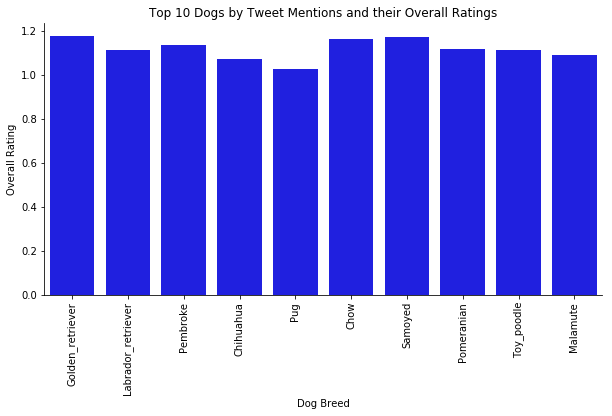

In [105]:
# Plot the top ten dog breeds by their tweet mentions and include their overall ratings
fig, axes = plt.subplots(figsize = (10,5))
sns.barplot(x = common_dogs, y = common_dogs_ratings, color = 'Blue', orient = 'v', axes = axes)
plt.xticks(rotation=90)
axes.set_title('Top 10 Dogs by Tweet Mentions and their Overall Ratings')
axes.set_xlabel('Dog Breed')
axes.set_ylabel('Overall Rating')
sns.despine()

#### Do the most common dogs also recieve the highest ratings?

In [106]:
df_dogs[['p1', 'overall_rating']].groupby('p1').agg(['mean', 'count']).sort_values(by = [('overall_rating', 'mean')], ascending = False).head(20)

overall_rating      
                                  mean count
p1                                          
Miniature_pinscher       1.429500       22  
Saluki                   1.250000       4   
Briard                   1.233333       3   
Tibetan_mastiff          1.225000       4   
Border_terrier           1.214286       7   
Standard_schnauzer       1.200000       1   
Giant_schnauzer          1.200000       3   
Silky_terrier            1.200000       1   
Eskimo_dog               1.177778       18  
Golden_retriever         1.175516       139 
Gordon_setter            1.175000       4   
Irish_setter             1.175000       4   
Samoyed                  1.170000       40  
Chow                     1.160976       41  
Cardigan                 1.152941       17  
Wire-haired_fox_terrier  1.150000       2   
Great_pyrenees           1.150000       14  
Australian_terrier       1.150000       2   
Kelpie                   1.145455       11  
Norfolk_terrier          1.142857       7

In [107]:
df_dogs[['p1','favorite_count']].groupby('p1').agg(['sum','mean','count']).sort_values(by = [('favorite_count', 'mean')], ascending = False).head(20)

favorite_count                    
                                    sum          mean count
p1                                                         
Flat-coated_retriever     129311         16163.875000  8   
Saluki                    62669          15667.250000  4   
Standard_poodle           105649         15092.714286  7   
Irish_water_spaniel       45167          15055.666667  3   
Giant_schnauzer           35702          11900.666667  3   
Norwegian_elkhound        82783          11826.142857  7   
Tibetan_mastiff           46574          11643.500000  4   
Cardigan                  193059         11356.411765  17  
Border_terrier            77354          11050.571429  7   
Afghan_hound              33143          11047.666667  3   
French_bulldog            282452         10863.538462  26  
Australian_terrier        21356          10678.000000  2   
Basset                    122260         9404.615385   13  
Briard                    27346          9115.333333   3   
Bedlington_terrier        44700          8940.000000   5   
Mexican_hairless          35640          8910.000000   4   
Chesapeake_bay_retriever  201277         8751.173913   23  
Cocker_spaniel            222710         8248.518519   27  
Golden_retriever          1145240        8239.136691   139 
Wire-haired_fox_terrier   16323          8161.500000   2

#### Is the popularity of a WeRateDog tweet affected by the month/ year it was tweeted?

In [108]:
df.timestamp.describe()

count     1994               
unique    1994               
top       2016-08-04 22:52:29
freq      1                  
first     2015-11-15 22:32:08
last      2017-08-01 16:23:56
Name: timestamp, dtype: object

In [112]:
# Extract the tweet month and year from the tweet timestamp
df['tweet_month'] = df['timestamp'].dt.month
df['tweet_year'] = df['timestamp'].dt.year

In [113]:
df.tweet_year.value_counts()

2016    974
2015    663
2017    357
Name: tweet_year, dtype: int64

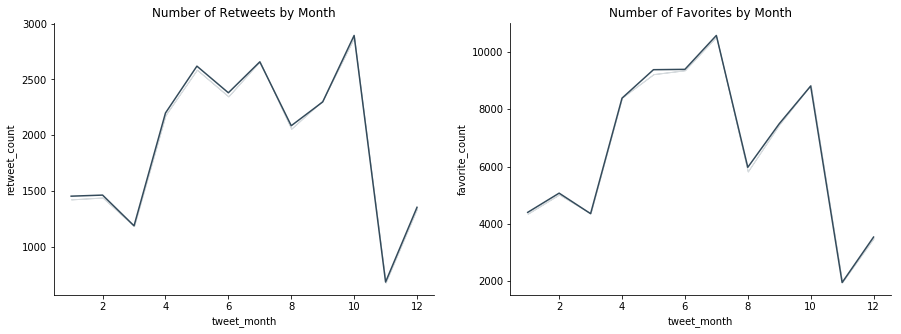

In [118]:
#Plot tweet favorites and tweet retweets by month

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

sns.set_palette("Blues_d")
sns.lineplot(x = 'tweet_month', y = 'retweet_count', data = df, ci = False, ax = axes[0]);
axes[0].set_title('Number of Retweets by Month')
sns.despine()

sns.lineplot(x = 'tweet_month', y = 'favorite_count', data = df, ci = False, ax = axes[1]);
axes[1].set_title('Number of Favorites by Month');
sns.despine()

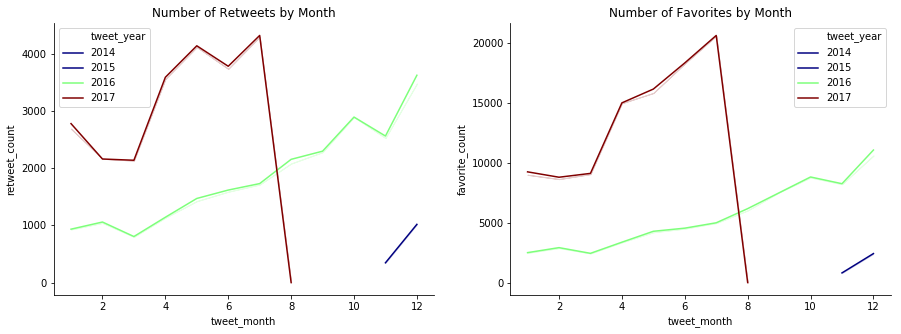

In [123]:
# Plot tweet favorites and tweet retweets by month and year

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

sns.set_palette("Blues_d")
sns.lineplot(x = 'tweet_month', y = 'retweet_count', data = df, ci = False, ax = axes[0], hue = 'tweet_year', palette= 'jet');
axes[0].set_title('Number of Retweets by Month')


sns.lineplot(x = 'tweet_month', y = 'favorite_count', data = df, ci = False, ax = axes[1], hue = 'tweet_year', palette= 'jet');
axes[1].set_title('Number of Favorites by Month');
sns.despine()

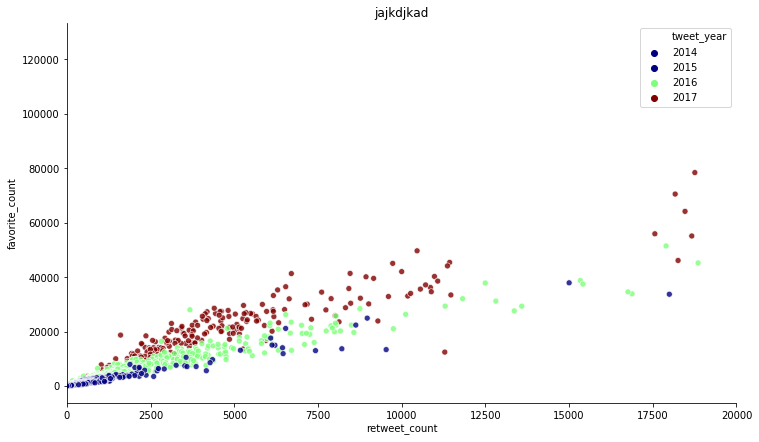

In [122]:
# Plot retweets vs favorite count, separated by year
fig, axes = plt.subplots(figsize=(12,7))

sns.scatterplot(x = 'retweet_count', y = 'favorite_count', data = df, hue = 'tweet_year', alpha = .8, palette = 'jet', axes = axes)
axes.set_title('jajkdjkad')
axes.set_xlim([0,20000])
sns.despine()